# 11.3 LSTM & Deep Forecasting for Financial Time Series
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

The objective is not to build a profitable trading strategy. Instead, we aim to answer a more fundamental research question:
*Do sequence-aware deep models extract additional predictive structure from financial time series compared to simpler temporal baselines?*

We adopt a diagnostic and empirical perspective, fully aware that the effectiveness of deep learning for return prediction remains highly controversial in the academic and practitioner literature. By default, all features and targets are derived from SPY daily data built from the notebook11.1

**This notebook**: 

In the previous Jupyter notebooks analysis, we modelled financial returns using tabular, pointwise supervised models. Each observation was treated as independent, even though financial time series are inherently sequential.

Here, we explicitly model temporal dependence using deep sequential models, focusing on LSTM networks.

Financial time series exhibit temporal ordering, volatility clustering, and regime changes. LSTM models are designed to capture long-range dependencies in sequences and are widely used in domains such as speech, text, and sensor data.

However, in finance:
- returns are noisy,
- signal-to-noise ratios are extremely low,
- markets are adaptive.

We wil test whether sequence-aware deep models can uncover additional structure beyond what standard supervised models capture.

# 0. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

We load the dataset produced in Notebook 01.
As before, it contains features + next-day return target, already aligned and cleaned.

In [2]:
df = pd.read_parquet("features_target_marketdata.parquet")

# Ensure correct datetime index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")

df = df.sort_index()
df.head()

,ret_log,ret_log_lag1,ret_log_lag5,ret_log_lag20,ret_log_z20,vol_5,vol_10,vol_20,vol_60,vol_ratio_5_20,...,sma_20,sma_50,ema_20,rsi_14,macd,macd_signal,macd_hist,drawdown,ret_log_autocorr_1_60,y_next_ret_log
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-27,0.002287,-0.002384,0.008788,-0.003412,0.373412,0.006396,0.008748,0.008693,0.008653,0.735794,...,173.656056,172.655002,173.523297,46.140542,-0.053570,0.228020,-0.281590,-0.025151,-0.097248,0.012126
2015-03-30,0.012126,0.002287,-0.001950,0.006294,1.415236,0.009920,0.008566,0.009040,0.008448,1.097374,...,173.539021,172.780757,173.589321,59.911480,0.014936,0.185403,-0.170467,-0.013258,-0.140380,-0.008778
2015-03-31,-0.008778,0.012126,-0.005635,-0.004113,-0.856962,0.010325,0.008997,0.009192,0.008435,1.123238,...,173.382088,172.868897,173.504051,56.326940,-0.053020,0.137718,-0.190738,-0.021881,-0.138158,-0.003543
2015-04-01,-0.003543,-0.008778,-0.014762,-0.004225,-0.291520,0.007867,0.007925,0.009180,0.008308,0.856899,...,173.231682,172.927833,173.368737,48.834276,-0.154376,0.079300,-0.233676,-0.025340,-0.187452,0.003591
2015-04-02,0.003591,-0.003543,-0.002384,0.001094,0.469686,0.007879,0.008032,0.009225,0.008007,0.854047,...,173.102652,172.948846,173.305276,53.802301,-0.182638,0.026912,-0.209550,-0.021834,-0.161331,0.000000


We define features and target.

In [3]:
target_col = "y_next_ret_log"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].copy()
y = df[target_col].copy()

X.shape, y.shape

((2792, 21), (2792,))

# 1. From Tabular Data to Temporal Sequencesces

Standard supervised models assume observations are independent:

$$x_t \in \mathbb{R}^d$$

Sequential models instead operate on windows of past observations:equential models instead operate on windows of past observations:

$$X_t = (x_{t-T+1}, \ldots, x_t) \in \mathbb{R}^{T \times d}$$

where:
- $T$ is the lookback window,
- $d$ is the number of features.

The lookback window $T$ is a hyperparameter:
- **too small** : no temporal context,
- **too large** : signal dilution and overfitting.

Longer sequences do not necessarily imply better predictability in finance


### Scaling & sequence construction

We standardize features using statistics computed only on the training set, to avoid leakage.

We then build rolling sequences with a fixed lookback window $T$

In [ ]:
# Lookback window
T = 30

# Time-based split
split_date = "2020-01-01"
mask_train = X.index < split_date
mask_test = ~mask_train

X_train_raw = X.loc[mask_train]
X_test_raw = X.loc[mask_test]

y_train_raw = y.loc[mask_train]
y_test_raw = y.loc[mask_test]

# Scale features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

We now construct rolling sequences.

In [ ]:
def build_sequences(X, y, T):
    X_seq, y_seq = [], []
    for i in range(T, len(X)):
        X_seq.append(X[i-T:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq_train, y_seq_train = build_sequences(
    X_train_scaled, y_train_raw.values, T
)

X_seq_test, y_seq_test = build_sequences(
    X_test_scaled, y_test_raw.values, T
)

X_seq_train.shape, y_seq_train.shape, X_seq_test.shape, y_seq_test.shape

((1213, 30, 21), (1213,), (1519, 30, 21), (1519,))

**Diagnostic checks:**

- sequences end strictly before the target,
- no future information leaks into the past,
- train/test separation is purely temporal.

# 2. Temporal Baselines

Before applying deep learning, we must verify whether simple temporal rules already capture most of the available signal.

If deep models cannot outperform these baselines, they add no value.

**Baseline 1 — Rolling mean predictor**

$$\hat{y}_t = \frac{1}{T} \sum_{i=0}^{T-1} r_{t-i}$$


In [ ]:
# Rolling mean baseline
rolling_mean_pred = []

returns_test = y_test_raw.values

for i in range(T, len(returns_test)):
    rolling_mean_pred.append(np.mean(returns_test[i-T:i]))

rolling_mean_pred = np.array(rolling_mean_pred)

rmse_rm = np.sqrt(mean_squared_error(y_seq_test, rolling_mean_pred))
mae_rm = mean_absolute_error(y_seq_test, rolling_mean_pred)

rmse_rm, mae_rm

(0.013244789163918651, 0.00847652796854092)

**Baseline 2 — Rolling momentum sign**

Predict the sign of the average past return.

In [ ]:
momentum_pred = np.sign(rolling_mean_pred)

directional_accuracy = np.mean(
    np.sign(y_seq_test) == momentum_pred
)

directional_accuracy

0.5128373930217248

**Baseline 3 — Linear regression on flattened sequences**

This baseline is very strong and often underestimates the value of LSTMs.

In [ ]:
from sklearn.linear_model import Ridge

X_flat_train = X_seq_train.reshape(len(X_seq_train), -1)
X_flat_test = X_seq_test.reshape(len(X_seq_test), -1)

lin_reg = Ridge(alpha=1.0)
lin_reg.fit(X_flat_train, y_seq_train)

y_pred_lin = lin_reg.predict(X_flat_test)

rmse_lin = np.sqrt(mean_squared_error(y_seq_test, y_pred_lin))
mae_lin = mean_absolute_error(y_seq_test, y_pred_lin)

rmse_lin, mae_lin

(0.017454023626930083, 0.012584475791861352)

- Temporal baselines already perform close to chance.
- Even a linear model on sequences struggles to extract stable signal.
- This highlights the intrinsic difficulty of the task.

# 3. LSTM Architecture & Training Setup

Vanilla RNNs suffer from vanishing gradients, making them ineffective at capturing long-range dependencies.

LSTMs address this via gating mechanisms:
- input gate: what new information to store,
- forget gate: what past information to discard,
- output gate: what to expose to the next layer.

In finance, we deliberately use small architectures to reduce overfitting.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

n_features = X_seq_train.shape[2]

model = Sequential([
    LSTM(32, input_shape=(T, n_features)),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,945 (27.13 KB)

 Trainable params: 6,945 (27.13 KB)

 Non-trainable params: 0 (0.00 B)

We use early stopping to prevent memorization of noise.

# 4. Training Dynamics & Stability

In [12]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_seq_train,
    y_seq_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

We inspect training dynamics.

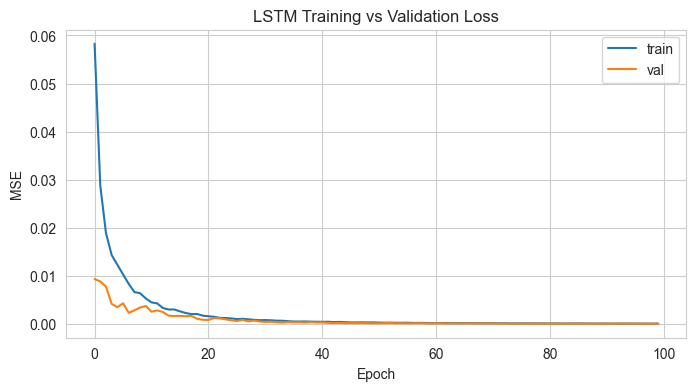

In [19]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

We generate predictions.

In [15]:
y_pred_lstm = model.predict(X_seq_test).flatten()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Residual diagnostics.

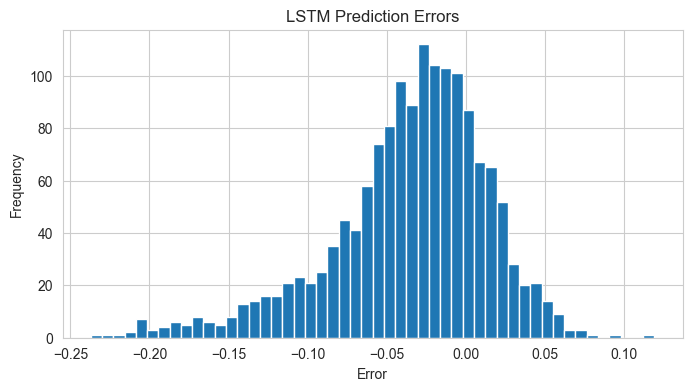

In [16]:
plt.hist(y_seq_test - y_pred_lstm, bins=50)
plt.title("LSTM Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

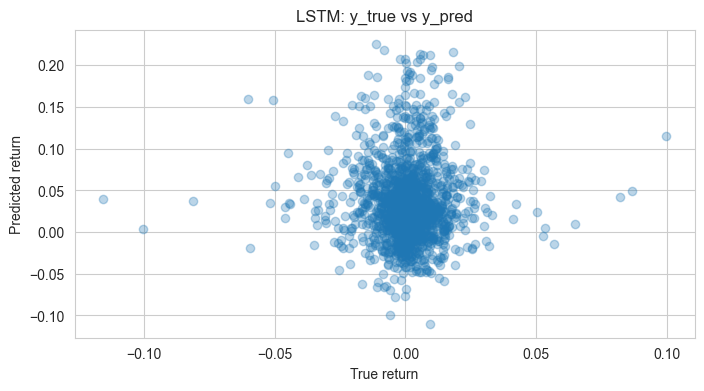

In [22]:
plt.scatter(y_seq_test, y_pred_lstm, alpha=0.3)
plt.xlabel("True return")
plt.ylabel("Predicted return")
plt.title("LSTM: y_true vs y_pred")
plt.show()

- Training and validation losses decrease smoothly and converge, indicating no obvious overfitting, but convergence alone does not imply predictive power.
- Prediction errors are centered near zero, with a wide dispersion, showing that the model mostly learns to predict small, average returns.
- The scatter of true vs predicted returns shows almost no linear relationship, confirming extremely weak correlation between predictions and outcomes.

# 6. Sensitivity to Lookback Window

We briefly test different lookback lengths.

In [23]:
lookbacks = [20, 40, 60]
rmse_by_T = []

for T_test in lookbacks:
    X_tr, y_tr = build_sequences(X_train_scaled, y_train_raw.values, T_test)
    X_te, y_te = build_sequences(X_test_scaled, y_test_raw.values, T_test)

    model_tmp = Sequential([
        LSTM(16, input_shape=(T_test, n_features)),
        Dense(1)
    ])
    model_tmp.compile(optimizer="adam", loss="mse")

    model_tmp.fit(X_tr, y_tr, epochs=20, batch_size=32, verbose=0)
    y_pred_tmp = model_tmp.predict(X_te).flatten()

    rmse_by_T.append(
        np.sqrt(mean_squared_error(y_te, y_pred_tmp))
    )

rmse_by_T

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[0.13020394065340996, 0.16699052655736882, 0.2827656195130543]

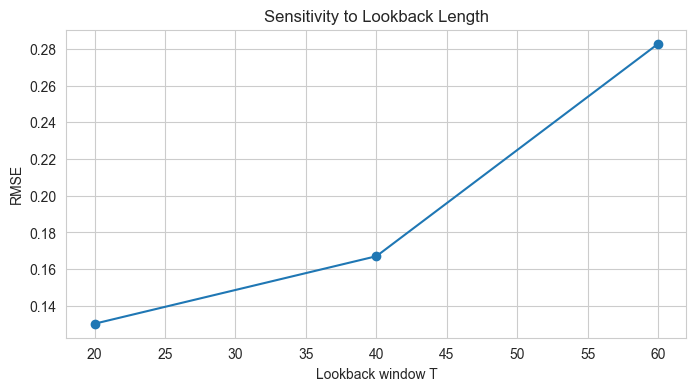

In [24]:
plt.plot(lookbacks, rmse_by_T, marker="o")
plt.xlabel("Lookback window T")
plt.ylabel("RMSE")
plt.title("Sensitivity to Lookback Length")
plt.show()

- Very short lookback windows fail to capture enough temporal structure.
- Increasing the lookback length quickly degrades performance, indicating signal dilution as noise accumulates.
- No clear optimal horizon emerges, reinforcing that temporal dependencies in daily SPY returns are weak and unstable.

# Conclusion

- Daily financial returns are close to white noise; both linear, tree-based, and deep models struggle to outperform simple baselines.
- Deep learning does not materially improve predictability over classical ML in this setting, despite its higher capacity.
- LSTMs are powerful sequence models, but model complexity does not compensate for weak signal.
- Small performance gains, when observed, are fragile, unstable across periods, and highly regime-dependent.

Feature engineering plays a central role, and model performance is largely constrained by the quality of the input features.
All models — linear, tree-based, and deep — depend heavily on the same engineered signals, suggesting that better feature design is likely more impactful than increasing model complexity.
Improving feature engineering and problem formulation is therefore a more promising direction than simply switching to more powerful models.